# Semi-Supervised Ensemble Model for Water Quality Prediction in Mexico

**Authors:** Raquel Cossío-Ramírez, Hortencia A. Ramírez-Vázquez, Amanda M. Valdez-Calderón

Mexico faces significant challenges in water contamination due to various factors, including natural contaminants, industrial pollution, agricultural runoff, urbanization, and overexploitation. As a result, 57% of the population lacks access to safe water.

This study’s objective is to create a semi-supervised ensemble model capable of predicting water quality by municipality based on environmental factors, such as population, inundability and industrial activity.

### Setup

Library imports, below are the necessary libraries for data processing, machine learning models, and evaluation metrics.

In [41]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, jaccard_score, balanced_accuracy_score, f1_score, precision_score, recall_score
import matplotlib.patches as mpatches
import geopandas as gpd # For .shp and .geoJSON files



In order to predict water quality for municipalities that were not covered by measuring stations, we opt to build a dataset with features that could be indirectly related to water quality. We included features per municipality such as [population](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469), [altitude](https://www.inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469), [area](http://geoportal.conabio.gob.mx/metadatos/doc/html/mun22gw.html), [flood-ability threshold](https://historico.datos.gob.mx/busca/dataset/peligro-por-inundaciones-a-nivel-municipal), [number of water treatment facilities and wastewater discharge points](http://www.inegi.org.mx/app/mapas/?t=81), and [number of people working in industries](https://www.inegi.org.mx/app/descarga/ficha.html?tit=2781025&ag=0&f=csv). In this notebook [AllData.csv](https://github.com/raqcoss/ML-water/blob/main/AllData.csv) is the integration of the datasets metioned above.

In [42]:
# Load dataset 
df = pd.read_csv("AllData.csv")
df.set_index("CVEGEO", inplace=True)
df = df.drop(labels=["NOM_ENT","NOM_MUN"], axis = 1)
df['semaforo'].replace({'Rojo':'Bad','Amarillo':'Medium', 'Verde':'Good'},inplace=True)

# Display data
df_copy = df.copy()
df

/tmp/ipykernel_217603/3489273614.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['semaforo'].replace({'Rojo':'Bad','Amarillo':'Medium', 'Verde':'Good'},inplace=True)


,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Bad
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Good
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Bad
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Bad
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Bad
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Bad
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Bad


The dataset consists of 2,469 rows and 13 columns, representing various geographical and environmental factors related to water quality assessment.
- **CVEGEO**: Unique geographical identifier for each municipality. 
- **POB_TOTAL**: Total population for each municipality.
- **ALTITUD**: Altitude of each municipality (in meters).
- **AREA**: Total area of each municipality (in square units).
- **UMBRAL12H**: Flooting threshold.
- **PORCENTA_1**: Percentage of flood-prone area.
- **agua_AR**: Water discharge point.
- **agua_FC**: Water intake structure.
- **agua_PT**: Drinking water service provider.
- **avg_impact**: Average human impact index.
- **avg_agricultura**, **avg_construccion**, **avg_manufactura**: Average levels of agricultural, construction, and manufacturing activities in the region.
- **semaforo**: Water quality indicator (Rojo = High risk, Amarillo = Moderate risk, Verde = Low risk, NaN = Missing data).

### Data Preprocessing and Normalization

In [43]:
# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["semaforo"]))
                          
X_scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=df.drop(columns=["semaforo"]).columns)
X_scaled_df['semaforo'] = df['semaforo']

## Labeled/Unlabeled Data Separation
X_labeled = X_scaled_df[X_scaled_df["semaforo"].notna()].copy()  
y = X_labeled["semaforo"]  # Target labels
X_labeled = X_labeled.drop(labels="semaforo", axis=1) 

# Unlabeled samples
X_unlabeled = X_scaled_df[X_scaled_df["semaforo"].isna()].copy() 
X_unlabeled = X_unlabeled.drop(labels="semaforo", axis=1)

# Encoding 'semaforo' column into numerical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])
y_encoded = y_encoded.astype(int)

# Dataset with encondig values
y_df = pd.DataFrame(y_encoded, index=y.index, columns=['semaforo_encoded'])
y_df["semaforo_encoded"] = y_df["semaforo_encoded"].replace(3, -1)

### Train-Test Split

Split the labeled dataset into training and testing sets
- 20% of the data is reserved for testing 
- 80% of the data is used for training

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X_labeled, y_df, test_size=0.2, random_state=42, stratify=y_df)

print(f"Train set: x_train = {x_train.shape} y_train = {y_train.shape}")


# Calculate weights per class and store in dictionary
df_weights = df.groupby(by='semaforo').count()['POB_TOTAL']
df_weights = df_weights / df_weights.sum()
# Display mapping of categorical labels 
print("\nMapping of categorical labels to numeric values")
class_weights = {}
for index, label in enumerate(le.classes_):
    print(f"{label} → {index}, weight: {df_weights.loc[label]}")
    class_weights[index] = df_weights.loc[label]
print(class_weights)

Train set: x_train = (836, 12) y_train = (836, 1)

Mapping of categorical labels to numeric values
Bad → 0, weight: 0.3107074569789675
Good → 1, weight: 0.2676864244741874
Medium → 2, weight: 0.4216061185468451
{0: 0.3107074569789675, 1: 0.2676864244741874, 2: 0.4216061185468451}


### Semi-Supervised Learning (SSL)

In this study, a SSL approach was employed to make use of both labeled and unlabeled data. 

It followed a self-training paradigm, in which an initial classifier trained on labeled data was iteratively refined using high-confidence predictions on unlabeled examples as pseudo-labels. Self-training was used along with an ensemble of three classification algorithms: **XGBoost**, **CatBoost** and **Random Forest**. Proposed SSL model architecture is presented in Figure 1.

<div style="text-align: center;">
    <img src="images/architecture.png" width="650" style="background-color: white; padding: 10px;">
    <p style="font-size:14px; color:gray;">Figure 1: Proposed SSL Model Architecture. The integrated dataset contains water quality labels for 1046 of the total 2478 Mexican municipalities. From which 20% of real labels is subsetted for cross validation while the remaining 80% is used for model training. Unlabeled municipalities are predicted using a selection strategy which chooses the maximum confidence value given by all models. Finally predicted values become pseudolabels only when confidence threshold of 0.7 is overcomed, while the rest of predictions remain unlabeled. Training and prediction processes are iterated at most 50 times to obtain more pseudolabels stopping when no more unlabed data remains.</p>
</div>

Selection strategy (Figure 2) of SSELM consists on selecting the label that obtained the maximum confidence within the different models predictions. Then pseudo-label asignment is performed only if the selected prediction surpasses the 0.75 confidence-threshold.

<div style="text-align: center;">
    <img src="images/selection_strategy.png" width="500" style="background-color: white; padding: 10px;">
    <p style="font-size:14px; color:gray;">Figure 2: Selection Strategy. Best-confidence predictions are assign as pseudolabels only when confidence is greater than 0.75.</p>
</div>


In [45]:
# Supervised Learning Models
model_names = ['CatBoostClassifier', 'XGBClassifier', 'RandomForestClassifier']
models = [CatBoostClassifier(iterations=500, class_weights=class_weights, verbose=0),
        XGBClassifier(max_depth=5, reg_alpha=1),
        RandomForestClassifier(max_samples=0.5, class_weight=class_weights)
]

### Training SSL Ensamble Model

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, f1_score
from sklearn.metrics import cohen_kappa_score


threshold = 0.75
max_iter = 50
metrics_df = pd.DataFrame(columns=['iteration','num_total_labels','num_new_predictions', 
                                   'num_new_High','num_new_Medium','num_new_Low',
                                   'accuracy', 'macro_avg_precision','macro_avg_recall', 
                                   'jaccard_score', 'macro_avg_F1', 'cohen_kappa'])
# Initialize metrics DataFrame
metrics_df.loc[0,['iteration','num_total_labels']] = [0,len(df_copy[df_copy['semaforo'].notna()])]

for iteration in range(max_iter):
    print(f"---------------------\nIteration {iteration + 1}")
    print(f'Training with {x_train.shape[0]} labels')

    # Train each model
    for model in models:
        y_train = np.squeeze(y_train)
        model.fit(x_train, y_train)

    # Predict probabilities for each model
    probas = [model.predict_proba(X_unlabeled) for model in models]

    # Normalize probabilities per model per sample
    norm_probas = []
    for p in probas:
        row_sums = p.sum(axis=1, keepdims=True)
        norm_p = p / row_sums
        norm_probas.append(norm_p)

    # Sum normalized probabilities across models
    summed_probas = np.sum(norm_probas, axis=0)

    # Calculate confidence and predicted class
    preds = np.argmax(summed_probas, axis=1)
    confidences = np.max(summed_probas, axis=1) / len(models)

    # Assign pseudo-labels only if confidence threshold is exceeded
    confident_mask = pd.Series(confidences >= threshold, index=X_unlabeled.index)
    if confident_mask.sum() == 0:
        print("No more confident pseudo-labels found.")
        break

    new_X = X_unlabeled.loc[confident_mask]
    new_y = preds[confident_mask]
    new_conf = confidences[confident_mask]

    # Build DataFrame for new pseudo-labels
    column_name = 'semaforo_encoded'
    new_y_df = pd.DataFrame(new_y, index=new_X.index, columns=[column_name])
    new_y_df['confidence'] = new_conf

    # Update training set
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_frame(name=column_name)
    y_train = pd.concat([y_train, new_y_df[[column_name]]], axis=0)
    x_train = pd.concat([x_train, new_X], axis=0)
    X_unlabeled = X_unlabeled.drop(index=new_X.index)

    # Metrics calculation
    num_total_labels = len(y_train)
    num_new_predictions = len(new_y_df)
    num_new_High = (new_y == 2).sum()
    num_new_Medium = (new_y == 1).sum()
    num_new_Low = (new_y == 0).sum()

    # Evaluate on test set
    test_probas = [model.predict_proba(x_test) for model in models]
    norm_test_probas = [p / p.sum(axis=1, keepdims=True) for p in test_probas]
    summed_test_probas = np.sum(norm_test_probas, axis=0)
    ensemble_preds = np.argmax(summed_test_probas, axis=1)

    accuracy = accuracy_score(y_test, ensemble_preds)
    macro_avg_precision = precision_score(y_test, ensemble_preds, average='macro')
    macro_avg_recall = recall_score(y_test, ensemble_preds, average='macro')
    jaccard = jaccard_score(y_test, ensemble_preds, average='macro')
    macro_avg_F1 = f1_score(y_test, ensemble_preds, average='macro')
    cohen_kappa = cohen_kappa_score(y_test, ensemble_preds)


    metrics_df.loc[iteration+1] = [iteration+1, num_total_labels, num_new_predictions, 
                                 num_new_High, num_new_Medium, num_new_Low,
                                 accuracy, macro_avg_precision, macro_avg_recall, 
                                 jaccard, macro_avg_F1, cohen_kappa]

    print(f"Added {confident_mask.sum()} new pseudo-labeled points. \n---------------------")

---------------------
Iteration 1
Training with 836 labels
Added 278 new pseudo-labeled points. 
---------------------
---------------------
Iteration 2
Training with 1114 labels
Added 277 new pseudo-labeled points. 
---------------------
---------------------
Iteration 3
Training with 1391 labels
Added 185 new pseudo-labeled points. 
---------------------
---------------------
Iteration 4
Training with 1576 labels
Added 115 new pseudo-labeled points. 
---------------------
---------------------
Iteration 5
Training with 1691 labels
Added 57 new pseudo-labeled points. 
---------------------
---------------------
Iteration 6
Training with 1748 labels
Added 45 new pseudo-labeled points. 
---------------------
---------------------
Iteration 7
Training with 1793 labels
Added 41 new pseudo-labeled points. 
---------------------
---------------------
Iteration 8
Training with 1834 labels
Added 26 new pseudo-labeled points. 
---------------------
---------------------
Iteration 9
Training wi

In [47]:
metrics_df['coverage'] = metrics_df['num_total_labels']/ len(X_scaled_df)

In [48]:
metrics_df

,iteration,num_total_labels,num_new_predictions,num_new_High,num_new_Medium,num_new_Low,accuracy,macro_avg_precision,macro_avg_recall,jaccard_score,macro_avg_F1,cohen_kappa,coverage
0,0,1046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.423653
1,1.0,1114.0,278.0,157.0,52.0,69.0,0.533333,0.504267,0.504866,0.343628,0.497509,0.270756,0.451195
2,2.0,1391.0,277.0,109.0,102.0,66.0,0.528571,0.497708,0.501121,0.341755,0.494604,0.265267,0.563386
3,3.0,1576.0,185.0,54.0,76.0,55.0,0.528571,0.489889,0.500296,0.339155,0.489978,0.267519,0.638315
4,4.0,1691.0,115.0,23.0,45.0,47.0,0.52381,0.495163,0.496816,0.337436,0.492109,0.258946,0.684893
5,5.0,1748.0,57.0,7.0,22.0,28.0,0.538095,0.504287,0.508611,0.347886,0.50097,0.279881,0.707979
6,6.0,1793.0,45.0,9.0,19.0,17.0,0.52381,0.486445,0.495168,0.333751,0.485024,0.259259,0.726205
7,7.0,1834.0,41.0,8.0,13.0,20.0,0.519048,0.487917,0.492247,0.331327,0.484731,0.251456,0.742811
8,8.0,1860.0,26.0,7.0,7.0,12.0,0.533333,0.500909,0.503483,0.342375,0.495957,0.271608,0.753341
9,9.0,1873.0,13.0,4.0,6.0,3.0,0.557143,0.529766,0.528007,0.365535,0.522663,0.308991,0.758607


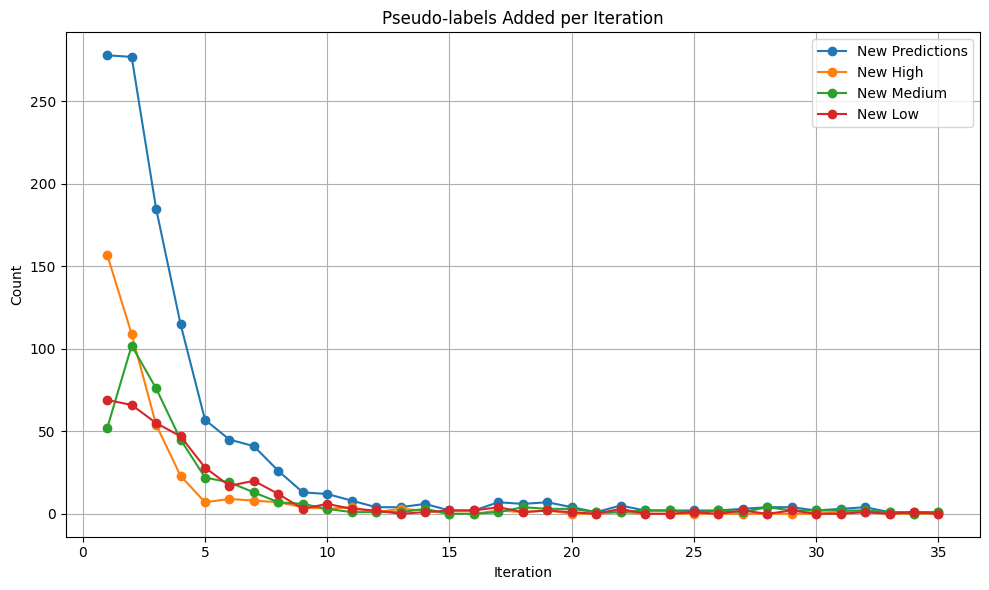

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(metrics_df['iteration'], metrics_df['num_new_predictions'], label='New Predictions', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['num_new_High'], label='New High', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['num_new_Medium'], label='New Medium', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['num_new_Low'], label='New Low', marker='o')

plt.xlabel('Iteration')
plt.ylabel('Count')
plt.title('Pseudo-labels Added per Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

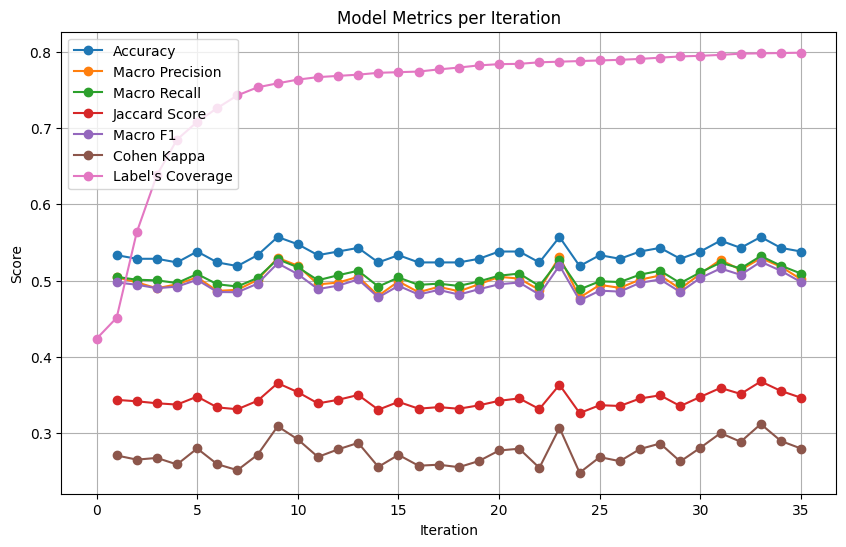

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(metrics_df['iteration'], metrics_df['accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['macro_avg_precision'], label='Macro Precision', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['macro_avg_recall'], label='Macro Recall', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['jaccard_score'], label='Jaccard Score', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['macro_avg_F1'], label='Macro F1', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['cohen_kappa'], label='Cohen Kappa', marker='o')
plt.plot(metrics_df['iteration'], metrics_df['coverage'], label="Label's Coverage", marker='o')


plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Model Metrics per Iteration')
plt.legend()
plt.grid(True)

### Testing SSL Ensamble Model

In [16]:
# Probabilities for each model
test_probas = [model.predict_proba(x_test) for model in models]
print(test_probas[0][0]) 
# Average probabilities across models
avg_test_probas = np.mean(test_probas, axis=0) 
print(avg_test_probas[0]) # Is this OK?
# Highest probability for each sample (Confidence level)
max_probs = np.max(avg_test_probas, axis=1)
ensemble_preds = np.argmax(avg_test_probas, axis=1)

# Ensable model's performance
print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_preds)*100:.2f}%")
print(f"Ensemble Model Balanced Accuracy {balanced_accuracy_score(y_test, ensemble_preds)*100:.2f}%")
print(f"Ensemble Model Jaccard Score {jaccard_score(y_test, ensemble_preds, average='weighted')*100:.2f}%")
print("\n",classification_report(y_test, ensemble_preds))

[0.08434215 0.09057187 0.82508598]
[0.14953314 0.09605531 0.75441157]
Ensemble Accuracy: 50.48%
Ensemble Model Balanced Accuracy 47.52%
Ensemble Model Jaccard Score 33.60%

               precision    recall  f1-score   support

           0       0.56      0.60      0.58        65
           1       0.30      0.20      0.24        56
           2       0.54      0.63      0.58        89

    accuracy                           0.50       210
   macro avg       0.47      0.48      0.47       210
weighted avg       0.48      0.50      0.49       210



#### Confusion Matrix

Confusion Matrix:
 [[39  7 19]
 [17 11 28]
 [14 19 56]]


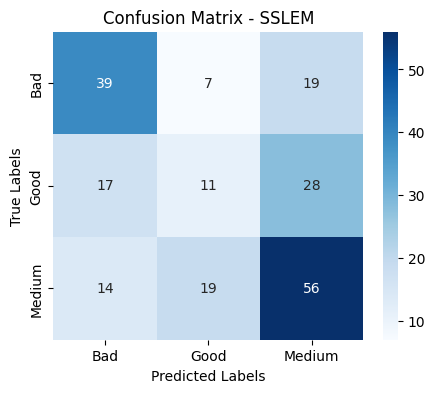

In [17]:
conf_matrix = confusion_matrix(y_test, ensemble_preds)

print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SSLEM")
plt.show()

### Predictions
This secton shows the predictions made by the proposed SSL Ensamble Model

In [18]:
# Concatenate all predictions
df_new = pd.concat([y_test, y_train], axis=0)
df_new = df_new.rename(columns={"semaforo_encoded": "preds"})

df_new


,preds
CVEGEO,
14108,2
7071,2
32026,0
32040,0
18015,2
...,...
16101,2
32028,0
21203,0


In [19]:
# Merging predictions with original dataset
df_copy = df_copy.merge(df_new[['preds']], left_index=True, right_index=True, how="left")
df_copy

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds
CVEGEO,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Bad,0.0
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Good,1.0
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Bad,0.0
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Bad,0.0
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Bad,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Bad,0.0
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Bad,0.0
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Bad,0.0


In [20]:
# Predictions
df_predictions = df_copy[df_copy["semaforo"].isna()]
df_predictions = df_predictions[df_predictions['preds'].notna()]
df_predictions

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds
CVEGEO,,,,,,,,,,,,,,
1009,22485,1948.772727,22966.10123,55.62216,2.539697,9,18,1,0.871654,0,0.000000,1.750000,NaN,0.0
5001,1022,433.357143,73795.65479,77.47371,2.789981,0,2,0,0.482459,0,0.000000,1.018018,NaN,1.0
5003,23056,398.580838,25062.53119,85.18428,1.989644,1,5,0,0.688818,0,8.000000,2.000000,NaN,2.0
5005,1643,484.421488,210281.65120,84.32739,1.071422,1,2,0,0.507179,0,0.000000,1.000000,NaN,1.0
5013,1735,181.340426,112385.32960,89.81352,4.875878,0,1,0,0.518360,0,0.000000,0.000000,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32022,19749,2048.115385,61692.10713,60.51915,0.856981,4,12,0,0.932514,0,5.666667,3.025641,NaN,0.0
32028,2451,1497.860215,48200.85044,67.96404,1.511670,3,8,0,0.703315,0,0.000000,1.000000,NaN,0.0
32031,8683,2082.835979,158297.61770,59.60943,1.461982,0,8,2,0.697977,0,6.000000,1.100000,NaN,0.0


### Comparison with Random Forest

A most commonly used approach is Random Forest, that combined the output of multiple decision trees to reach a prediction. It utilizes the bagging method and feature randomness, only selecting a subset of all possible features, to create an uncorrelated forest of decision trees.

/home/raqcoss/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.64      0.59        67
           1       0.41      0.18      0.25        50
           2       0.62      0.72      0.67        93

    accuracy                           0.57       210
   macro avg       0.52      0.51      0.50       210
weighted avg       0.54      0.57      0.54       210



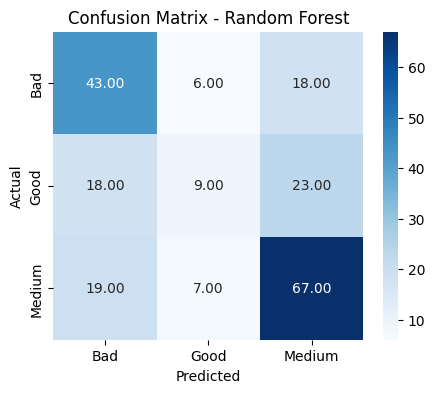

In [21]:

# Define features and target
X = X_labeled 
y = y

# Enconding 'semaforo' label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Training 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Testing
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

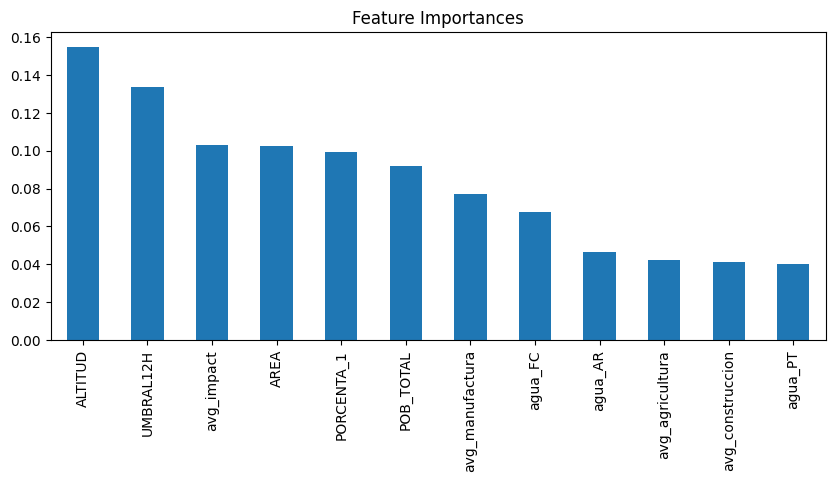

In [22]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature Importances")
plt.show()

### Visualisation on Mexican map

In [28]:
#Defining function for plotting

def viz_on_map(df, alpha_col = None,alpha = None, color_col = 'semaforo', color_map = {
    'Bad': 'red',
    'Medium': 'gold',
    'Good': 'green'},
    title ='Water Quality Indicator by Municipality'):
    ''' This function makes a previev of the column 'semaforo' on the map of Mexico '''

    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    if alpha_col:
        columns_to_plot = [alpha_col,color_col]
    else:
        columns_to_plot = color_col
    df = mun_geo.merge(df[columns_to_plot], how = 'outer', left_on='CVEGEO', right_index=True)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))

    # 1. First plot all geometries with full opacity (for borders)
    df.boundary.plot(ax=ax, color='black', linewidth=0.2)

    # 2. Create a new column for plotting colors
    df['plot_color'] = df[color_col].map(color_map).fillna('gray')

    # 3. Plot with confidence-based alpha
    for class_name in color_map.keys():
        # Filter features for this class
        class_data = df[df[color_col] == class_name]
        if not class_data.empty:
            # Plot with variable alpha
            if alpha_col is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha=class_data[alpha_col].fillna(0),  # Use confidence for alpha
                    edgecolor='none',
                    label=class_name)
            elif alpha is not None:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    alpha = alpha,
                    edgecolor='none',
                    label=class_name)
            else:
                class_data.plot(
                    ax=ax,
                    color=class_data['plot_color'],
                    edgecolor='none',
                    label=class_name)

    # 4. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=class_name,
            alpha=1.0
        ))
    
    if alpha_col is not None:
        # Add confidence explanation
        confidence_elements = [
            mpatches.Patch(color='gray', alpha=0.3, label='Low Confidence (~50%)'),
            mpatches.Patch(color='gray', alpha=0.6, label='Medium Confidence (~70%)'),
            mpatches.Patch(color='gray', alpha=1, label='High Confidence (~100%)')
            ]
        ax.legend(
            handles=legend_elements + confidence_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
    )
    else:
        ax.legend(
            handles=legend_elements,
            title='Semaforo Classes & Confidence',
            loc='upper right'
        )
        title = title

    plt.title(title)
    plt.tight_layout()
    plt.show()

In [29]:
def viz_on_map_with_predictions(df, df_predicted, 
                              color_col='semaforo', 
                              pred_col='preds_label',
                              color_map = {'Bad': 'red',
                                           'Medium': 'gold',
                                           'Good': 'green'},
                              title='Water Quality Indicator by Municipality'):
    '''
    This function visualizes both known and predicted water quality indicators on the map of Mexico.
    Known values (semaforo) are shown with alpha=1, predicted values with alpha=0.5.
    
    Parameters:
    - df: DataFrame with known values in 'semaforo' column
    - df_predicted: DataFrame with predicted values in 'preds_label' column
    - color_col: Column name for known values (default 'semaforo')
    - pred_col: Column name for predicted values (default 'preds_label')
    - color_map: Color mapping dictionary
    - title: Plot title
    '''
    # Load municipality shapes
    municipios_path = 'mun22gw/mun22gw.shp'
    municipios = gpd.read_file(municipios_path)
    municipios['CVEGEO'] = municipios['CVEGEO'].astype(int)
    mun_geo = municipios[['CVEGEO','geometry']].set_index('CVEGEO')
    
    # Merge with known values
    df_plot = mun_geo.merge(df[[color_col]], how='left', left_on='CVEGEO', right_index=True)
    
    # Merge with predicted values if available
    if pred_col in df_predicted.columns:
        df_plot = df_plot.merge(df_predicted[[pred_col]], how='left', left_on='CVEGEO', right_index=True)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 1. First plot all geometries with full opacity (for borders)
    df_plot.boundary.plot(ax=ax, color='black', linewidth=0.2)
    
    # 2. Create color columns
    df_plot['known_color'] = df_plot[color_col].map(color_map).fillna('gray')
    if pred_col in df_plot.columns:
        df_plot['pred_color'] = df_plot[pred_col].map(color_map).fillna('gray')
    
    # 3. Plot known values with alpha=1
    for class_name in color_map.keys():
        class_data = df_plot[df_plot[color_col] == class_name]
        if not class_data.empty:
            class_data.plot(
                ax=ax,
                color=class_data['known_color'],
                alpha=1,
                edgecolor='none',
                label=f'Known {class_name}'
            )
    
    # 4. Plot predicted values with alpha=0.5 (if available)
    if pred_col in df_plot.columns:
        for class_name in color_map.keys():
            class_data = df_plot[df_plot[pred_col] == class_name]
            if not class_data.empty:
                class_data.plot(
                    ax=ax,
                    color=class_data['pred_color'],
                    alpha=0.4,
                    edgecolor='none',
                    label=f'Predicted {class_name}'
                )
    
    # 5. Create custom legend
    legend_elements = []
    for class_name, color in color_map.items():
        legend_elements.append(mpatches.Patch(
            color=color,
            label=f'Known {class_name}',
            alpha=1.0
        ))
        legend_elements.append(mpatches.Patch(
            color=color,
            label=f'Predicted {class_name}',
            alpha=0.5
        ))
    
    ax.legend(
        handles=legend_elements,
        title='Water Quality Indicators',
        loc='upper right'
    )
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [30]:
# Build class-decoding map
decode_map = {}
for index, label in enumerate(le.classes_):
    decode_map[index] = label
# Decode labels
df_copy['preds_label'] = df_copy['preds'].replace(decode_map)
df_copy

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds,preds_label
CVEGEO,,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Bad,0.0,Bad
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Good,1.0,Good
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Bad,0.0,Bad
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Bad,0.0,Bad
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Bad,0.0,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Bad,0.0,Bad
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Bad,0.0,Bad
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Bad,0.0,Bad


In [31]:
df_predictions['preds_label'] = df_predictions['preds'].replace(decode_map)


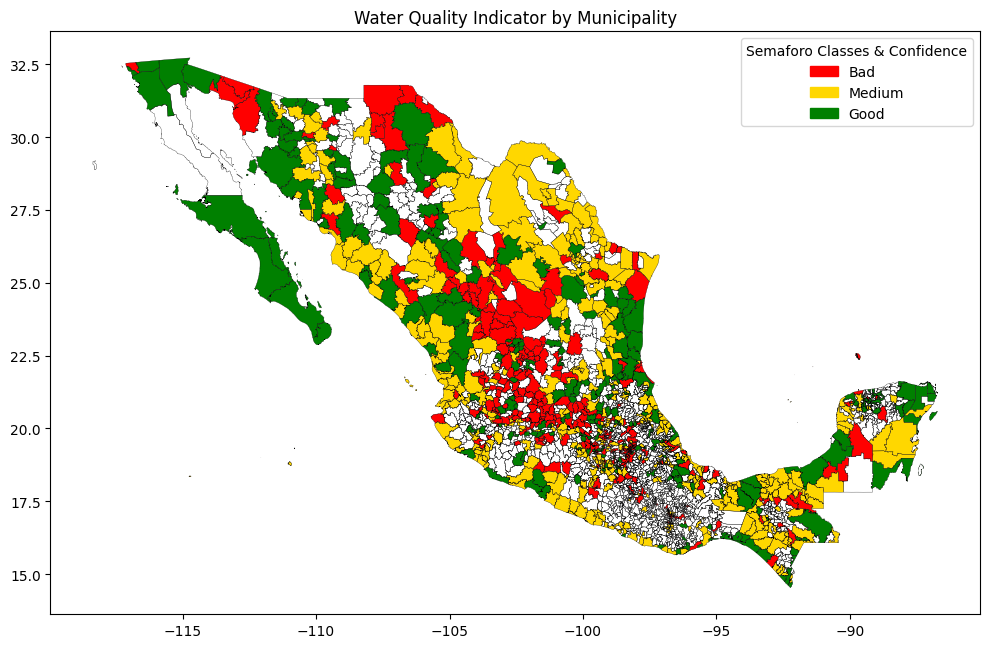

In [32]:
viz_on_map(df_copy, color_col='semaforo')

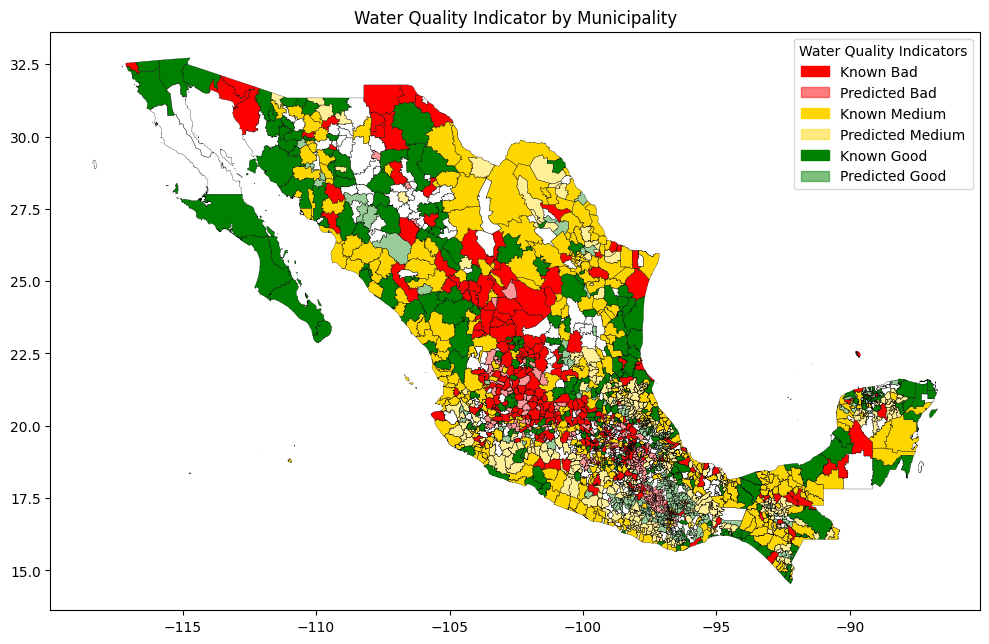

In [34]:
viz_on_map_with_predictions(df_copy, df_predictions, 
                              color_col='semaforo', 
                              pred_col='preds_label',
                              title='Water Quality Indicator by Municipality')

In [35]:
total_rows = len(df_copy)
original_labels_num = len(df_copy[df_copy['semaforo'].notna()])
predicted_labels_num = len(df_predictions[df_predictions['preds'].notna()])
final_labels_num = original_labels_num + predicted_labels_num
print(f'Municipalities considered in the dataset: {total_rows}')
print(f'Original labels: {original_labels_num}')
print(f"Pseudo-labels: {predicted_labels_num}")
print(f'Labels + pseudo-labels: {final_labels_num}')
print(f'Label coverage was extended from {(original_labels_num/total_rows)*100:.2f}% to {(final_labels_num/total_rows)*100:.2f}%')


Municipalities considered in the dataset: 2469
Original labels: 1046
Pseudo-labels: 1167
Labels + pseudo-labels: 2213
Label coverage was extended from 42.37% to 89.63%


In [36]:
print('Corrected metrics accounting for the 2478 municipalities')
print(f'Corrected initial coverage: {(original_labels_num/2478)*100:.2f}%')
print(f'Corrected final coverage: {final_labels_num/2478*100:.2f}%')


Corrected metrics accounting for the 2478 municipalities
Corrected initial coverage: 42.21%
Corrected final coverage: 89.31%


In [37]:
y_train["semaforo_encoded"].value_counts()

semaforo_encoded
2    348
0    258
1    230
Name: count, dtype: int64

In [38]:
df_copy

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo,preds,preds_label
CVEGEO,,,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Bad,0.0,Bad
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Good,1.0,Good
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Bad,0.0,Bad
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Bad,0.0,Bad
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Bad,0.0,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Bad,0.0,Bad
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Bad,0.0,Bad
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Bad,0.0,Bad


In [39]:
df_copy.groupby('preds_label',)['AREA'].sum().sort_values(ascending=False)

preds_label
Medium    7.343479e+07
Good      5.937063e+07
Bad       3.630447e+07
Name: AREA, dtype: float64

In [40]:
# Considering Area instead of municipalities
total_area = df_copy['AREA'].sum() # in km

# Original dataset
print("Original dataset:")
orig_counts = df_copy['semaforo'].value_counts()
orig_areas = df_copy.groupby('semaforo')['AREA'].sum()
for label in orig_counts.index:
    print(f"{label}-quality water was observed in {orig_counts.loc[label]} municipalities, accounting for {orig_areas[label]/total_area*100:.2f}% of Mexico's total territory.")
print("Land Coverage: {:.2f}%".format((orig_areas.sum()/total_area)*100))
print("\n")
# Only predictions
print("Predictions:")
pred_counts = df_predictions['preds_label'].value_counts()
pred_areas = df_predictions.groupby('preds_label')['AREA'].sum()
for label in pred_counts.index:
    print(f"{label}-quality water was predicted for {pred_counts.loc[label]} municipalities, accounting for {pred_areas[label]/total_area*100:.2f}% of Mexico's total territory.")
print("Land Coverage: {:.2f}%".format((pred_areas.sum()/total_area)*100))
print("\n")
# Combined dataset
print("Combined dataset:")
combined_counts = df_copy['preds_label'].value_counts()
combined_areas = df_copy.groupby('preds_label')['AREA'].sum()
for label in combined_counts.index:
    print(f"{label}-quality water was observed or predicted for {combined_counts.loc[label]} municipalities, accounting for {combined_areas[label]/total_area*100:.2f}% of Mexico's total territory.")
print("Final Land Coverage: {:.2f}%".format((combined_areas.sum()/total_area)*100))

Original dataset:
Medium-quality water was observed in 441 municipalities, accounting for 28.46% of Mexico's total territory.
Bad-quality water was observed in 325 municipalities, accounting for 16.16% of Mexico's total territory.
Good-quality water was observed in 280 municipalities, accounting for 26.42% of Mexico's total territory.
Land Coverage: 71.04%


Predictions:
Medium-quality water was predicted for 493 municipalities, accounting for 9.34% of Mexico's total territory.
Bad-quality water was predicted for 341 municipalities, accounting for 2.53% of Mexico's total territory.
Good-quality water was predicted for 333 municipalities, accounting for 4.15% of Mexico's total territory.
Land Coverage: 16.01%


Combined dataset:
Medium-quality water was observed or predicted for 934 municipalities, accounting for 37.80% of Mexico's total territory.
Bad-quality water was observed or predicted for 666 municipalities, accounting for 18.69% of Mexico's total territory.
Good-quality water wa